In [9]:
import numpy as np
from commpy.filters import rrcosfilter

# Define the file path and data type
file_path = './rx_data_raw_4_UHF240312T200612'  # Replace with the actual file path
dtype = np.complex64  # 32-bit complex data type

#Calculate the number of elements to read for 1 GB of data
bytes_to_read = 8 * 1024 * 1024 * 1024  # 1 GB in bytes
complex_size = 64
elements_to_read = 1 * bytes_to_read // complex_size
#Read the first gigabyte of data
data = np.fromfile(file_path, dtype=dtype, count=elements_to_read)

# # Read all the data
# data = np.fromfile(file_path, dtype=dtype)

# If you want to reshape the data into a 1D array of complex numbers, you can do:
data = data.reshape(-1)

#len(data) * complex_size / 8, data


In [10]:
import matplotlib.pyplot as plt
import math
from scipy.signal import butter, lfilter, freqz

# Calculate the time values based on the sample rate (500 ksps)
sample_rate = 500e3  # 500 ksps
time = np.arange(len(data)) / sample_rate
fsk_deviation = 1.1e3
symbol_rate = 1e3 # symbols per second
samples_per_symbol = sample_rate / symbol_rate

# Multiply by a sine wave if the input is too close to 0 frequency
# data = data * (np.sin(2 * np.pi * time * 5e3) - 1j * np.cos(2 * np.pi * time * 5e3))

# Run the data through a low pass filter data
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

cutoff = 10e3 # Hz
filtered_data = butter_lowpass_filter(data, cutoff, sample_rate, 5)

# Demodulate the data
# Option 1 uses proper Quadrature demodulation, 
#   numeric version of the imaginary part of the derivative of the natural log of the input
demodulated_data = 0.5 * sample_rate * (1 / (math.pi * fsk_deviation)) * np.angle(filtered_data[0:-1] * np.conj(filtered_data[1:]))

# Option 2 takes the real part of the derivative of the natural log of the input
#demodulated_data = np.abs(filtered_data * np.conj(filtered_data))

# Scale and Center the data
# demodulated_data *= 2
# demodulated_data += 0.5

In [11]:
# Apply a root raised cosine filter
root_raised_cosine_filter = rrcosfilter(int(samples_per_symbol), 0.8, 1 / symbol_rate, sample_rate)[1]
# Analog signal has N/2 leading and trailing near-zero samples
demodulated_data = np.convolve(root_raised_cosine_filter, demodulated_data, mode='valid') / samples_per_symbol

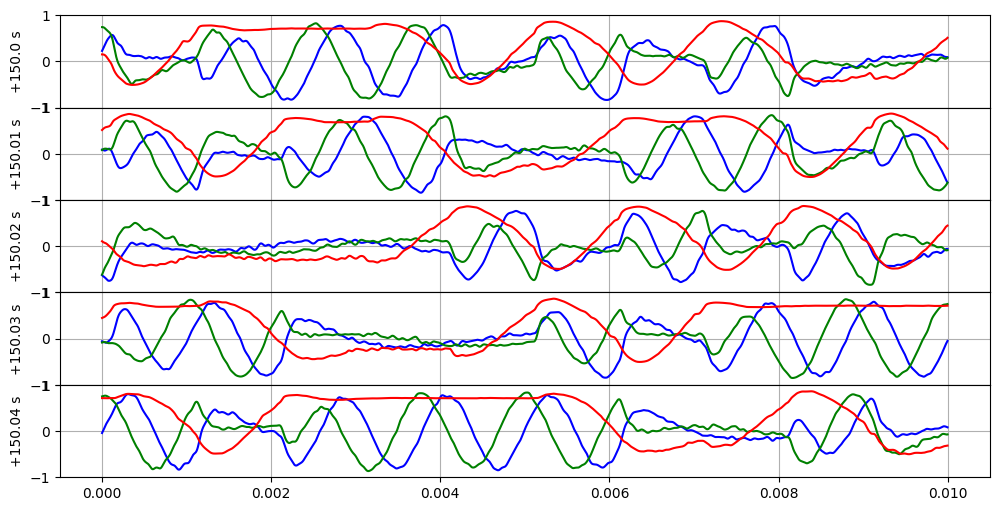

In [12]:
# Create a single figure with num_intervals subplots for interval_duration
start_offset = 150
num_intervals = 5
interval_duration = 0.01  # seconds
total_duration = num_intervals * interval_duration  # seconds

fig, axes = plt.subplots(num_intervals, 1, figsize=(12, 6), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i, ax in enumerate(axes):
    start_time = i * interval_duration + start_offset
    end_time = (i + 1) * interval_duration + start_offset
    start_sample = int(start_time * sample_rate)
    end_sample = int(end_time * sample_rate)
    
    ax.plot(time[start_sample:end_sample] - time[start_sample], 
        np.real(filtered_data[start_sample:end_sample]), label='Real Part', color='blue')
    ax.plot(time[start_sample:end_sample] - time[start_sample], 
        np.imag(filtered_data[start_sample:end_sample]), label='Imaginary Part', color='green')
    ax.plot(time[start_sample:end_sample] - time[start_sample], 
        demodulated_data[start_sample:end_sample], label='Demodulated Data', color='red')
    ax.set_ylabel('+' + str(start_time) + ' s')
    #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
    ax.grid(True)
    ax.set_ylim(-1, 1)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([1, 0, '1/-1'])
    # ax.legend()

In [ ]:
np.max(demodulated_data), np.min(demodulated_data)

In [13]:
# Sliding window average
sliding_window_kernel = np.ones(int(samples_per_symbol))
sliding_window_average = np.convolve(demodulated_data, sliding_window_kernel, 'valid') / 1000

# Take the derivative of the sliding window average
derivative_sliding_window_average = np.gradient(sliding_window_average)
derivative_range = np.max(derivative_sliding_window_average) \
    - np.min(derivative_sliding_window_average)
derivative_sliding_window_average /= derivative_range 
derivative_sliding_window_average = np.abs(derivative_sliding_window_average)

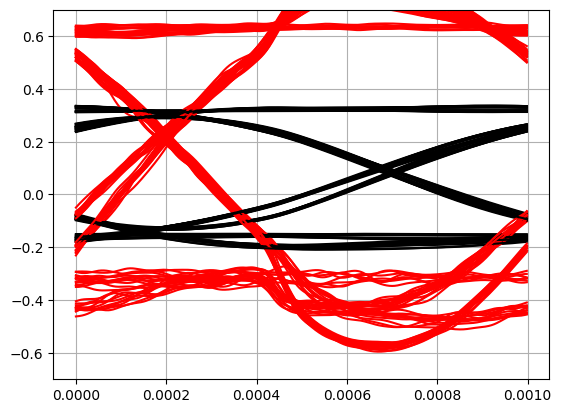

In [14]:
# Plot an eye diagram using the sliding window average
plt.figure()
time = np.arange(len(data)) / sample_rate
symbol_duration = 1 / symbol_rate
eye_diagram_start_offset = 100
symbol_decimation = 10
tau = 0.0004

for i in range(100):
    start_time = symbol_decimation*i * symbol_duration + eye_diagram_start_offset 
    end_time = (symbol_decimation*i + 1) * symbol_duration + eye_diagram_start_offset  
    start_sample = int(start_time * sample_rate) 
    end_sample = int(end_time * sample_rate)

    plt.plot(time[start_sample:end_sample] - time[start_sample], 
        demodulated_data[start_sample:end_sample], color='red')
    plt.plot(time[start_sample:end_sample] - time[start_sample], 
        sliding_window_average[start_sample:end_sample], color='black')

    #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
    plt.grid(True)
    plt.ylim(-0.7, 0.7)

#plt.vlines(tau_s[int(200 * sample_rate / samples_per_symbol)] - 0.004, -0.5, 0.5)

plt.show()

In [15]:
# Huersitc symbol synchronizer

symbols_to_average = 100

# clip the number of samples to the nearest integer number of symbols
jagged_edge = samples_per_symbol * (len(derivative_sliding_window_average) // samples_per_symbol)
two_d_view = np.reshape(derivative_sliding_window_average[0:int(jagged_edge)], (-1, 500))

# Sum n symbol derivatives with m following symbol derivative windows
def rollrep(arr):
    arr = np.roll(arr,axis=0, shift=1)
    arr[0,:] = 0
    return arr 

sum_two_d = np.zeros_like(two_d_view)
last_roll = two_d_view
for i in range(symbols_to_average):
    curr_roll = rollrep(last_roll)
    sum_two_d += curr_roll
    last_roll = curr_roll

# The min of each of n sums of length of samples per symbol is the ideal sampling point
possible_taus = np.arange(0, samples_per_symbol) / sample_rate
tau_s = possible_taus[np.argmin(sum_two_d, axis=1)]

# unwrap the ideal sampling points if they are all moving in the same direction
unwrap_cutoff = np.median(possible_taus)
unwrap_offset = 0
tau_s = np.unwrap(tau_s, period=unwrap_cutoff)

Text(0.5, 0, 'Time (s)')

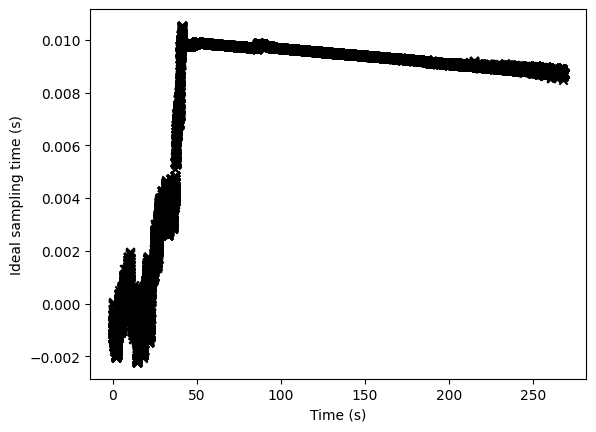

In [16]:
# Plot the tau_s
plt.figure()
tau_time_stamps = time[::int(samples_per_symbol)][:-3]
plt.scatter(tau_time_stamps, tau_s, marker='x', color='black')
plt.ylabel('Ideal sampling time (s)')
plt.xlabel('Time (s)')

IndexError: index 250 is out of bounds for axis 0 with size 0

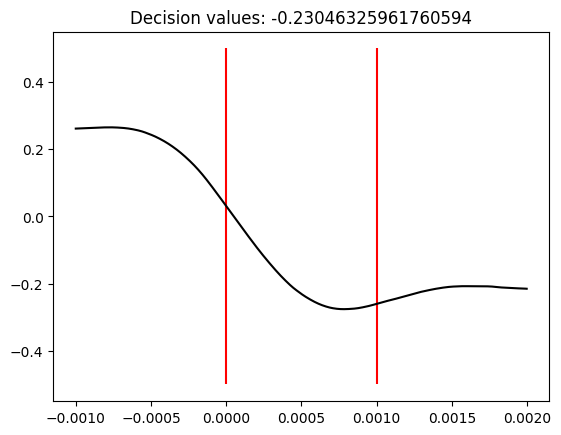

In [30]:
# Apply the heuristic tau's
plt.figure()
decision_values = []
symbol_duration = 1 / symbol_rate
for i, tau in enumerate(tau_s):
    tau_sample_offset = int(samples_per_symbol * (tau / symbol_duration) + 0.5 * samples_per_symbol * symbols_to_average)
    begin_sample = int((i+3) * samples_per_symbol) + tau_sample_offset
    end_sample = int((i+4) * samples_per_symbol) + tau_sample_offset
    window = sliding_window_average[begin_sample:end_sample] - 0.1
    if len(window) == samples_per_symbol:
        decision_values.append(window[int(samples_per_symbol / 2)])

    if i == 1000 * 150: 
        plt.vlines(0, -0.5, 0.5, color='red')
        plt.vlines(time[int(samples_per_symbol)], -0.5, 0.5, color='red')
        plt.plot(time[begin_sample - 500 :end_sample + 500] - time[begin_sample], 
            sliding_window_average[begin_sample - 500 :end_sample + 500] - 0.1, color='black')
        plt.title('Decision values: ' + str(decision_values[-1]))

bits = np.greater(decision_values, np.zeros_like(decision_values))

In [ ]:
max_errors_per_clip_range=200
start_tx_index = 30 #s
start_rx_index = 0 #raw index value which is clip_range * seconds
tries = 100
time = np.arange(len(data)) / sample_rate

with open("../../tx_data", 'rb') as transmitted_binary:
    transmitted_array = np.asarray(bytearray(transmitted_binary.read()))

transmitted_bits = np.unpackbits(transmitted_array)
received_bits = 1 - bits.astype('uint8')

tau_min = 0

clip_range = 1000 # bits
ith_kbit = -1

total_number_of_clips = int(len(transmitted_bits)/clip_range)
total_number_of_clips = 60 * 20
for n in range(tries):
    number_of_errors = len(received_bits)
    for i in range(start_tx_index, total_number_of_clips):
        clipped_transmitted_bits = transmitted_bits[i*clip_range:(i+1)*(clip_range)]
        min_number_of_errors_per_i = clip_range
        # Search for the minimum number of errors caused by the start of the data sequence
        for tau in range(start_rx_index, len(received_bits) - len(clipped_transmitted_bits)):
            error_bits = np.abs(np.ndarray.astype(clipped_transmitted_bits, np.byte) \
                - np.ndarray.astype(received_bits[tau:tau+len(clipped_transmitted_bits)], np.byte))
            temp = np.sum(error_bits)
            if temp < min_number_of_errors_per_i:
                min_number_of_errors_per_i = temp

            if temp < number_of_errors:
                number_of_errors = temp
                tau_min = tau

            if temp < max_errors_per_clip_range:
                number_of_errors = temp
                tau_min = tau
                break
        print('{0}/{1}'.format(min_number_of_errors_per_i,clip_range) \
                + ' errors found in clip index i=' + str(i) \
                + '/' + str(total_number_of_clips), end='\r')
        
        if number_of_errors < max_errors_per_clip_range:
            ith_kbit = i
            break

    # Once the first fully correct clip range is found, 
    # look for the last block that has less than max_errors_per_clip_range

    # Update this block to find skip errors, and then keep going
    end_number_of_errors = clip_range
    end_tau = tau_min
    total_errors = 0
    total_sensed_clips = 0
    skip_offset = 0
    tx_offset = i

    length = 100
    skip_search = []
    for j in range(1, length // 2 + 1):
        skip_search.extend([j, -j])

    def estimate_errors(tau):
        clipped_transmitted_bits = transmitted_bits[tx_offset*clip_range:(tx_offset+1)*(clip_range)]
        error_bits = np.abs(np.ndarray.astype(clipped_transmitted_bits, np.byte) \
            - np.ndarray.astype(received_bits[tau:tau+len(clipped_transmitted_bits)], np.byte))
        return np.sum(error_bits)

    for tau in range(tau_min, len(received_bits) - len(clipped_transmitted_bits), clip_range):
        temp = estimate_errors(tau + skip_offset)

        end_number_of_errors = temp
        
        if temp > max_errors_per_clip_range:
            # for skip in skip_search:
            #     temp = estimate_errors(tau + skip)
            #     if temp < max_errors_per_clip_range:
            #         skip_offset = skip
            #         total_errors += temp
            #         display('break')
            #         break
            end_tau = tau
            break
        else:
            total_errors += temp
            total_sensed_clips += 1
        
        tx_offset += 1

    # min_error_bits = np.abs(np.ndarray.astype(transmitted_bits, np.byte) \
    #         - np.ndarray.astype(received_bits[tau_min:tau_min+len(transmitted_bits)], np.byte))

    bit_error_rate = total_errors / (end_tau - tau_min)

    print()
    print('TX Data Length: ' + str(len(transmitted_bits)))
    print('RX Data Length: ' + str(len(received_bits)))
    print(f'Clean data found from RX {tau_min//1000}s (i={tau_min}) to {end_tau//1000}s (i={end_tau}), for a total length {(end_tau - tau_min) // 1000}s')
    print(f'\tTX data indexes from {i}s to {tx_offset}s')
    print('Errors in the first clip range {0}'.format(number_of_errors))
    print(f'Errors in the last clip range {end_number_of_errors}, (RX i = {end_tau} to {end_tau + len(clipped_transmitted_bits)})')
    print('Bit Error Rate (BER): ' + str(bit_error_rate))
    print(f'Total Sensed Clips {total_sensed_clips}')
    print()
    print(str(received_bits[tau_min:tau_min+40]))
    print(str(transmitted_bits[ith_kbit*clip_range:ith_kbit*clip_range+40]))

    plt.figure()
    plt.title(f'RX index {tau_min}, TX index {i}')
    for i in range(1000):
        start_time = i * symbol_duration 
        end_time = (i + 1) * symbol_duration
        start_sample = int(start_time * sample_rate + sample_rate * tau_min / 1000) 
        end_sample = int(end_time * sample_rate + sample_rate * tau_min / 1000)

        # plt.plot(time[start_sample:end_sample] - time[start_sample], 
        #     demodulated_data[start_sample:end_sample], color='red')
        plt.plot(time[start_sample:end_sample] - time[start_sample], 
            sliding_window_average[start_sample:end_sample], color='black')

        #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
        plt.grid(True)
        #plt.ylim(-0.5, 0.5)
    plt.show()

    plt.figure()
    plt.title(f'RX index {end_tau}, TX index {tx_offset}')
    for i in range(1000):
        start_time = i * symbol_duration 
        end_time = (i + 1) * symbol_duration
        start_sample = int(start_time * sample_rate + sample_rate * end_tau / 1000) 
        end_sample = int(end_time * sample_rate + sample_rate * end_tau / 1000)

        # plt.plot(time[start_sample:end_sample] - time[start_sample], 
        #     demodulated_data[start_sample:end_sample], color='red')
        plt.plot(time[start_sample:end_sample] - time[start_sample], 
            sliding_window_average[start_sample:end_sample], color='black')

        #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
        plt.grid(True)
        #plt.ylim(-0.5, 0.5)
    plt.show()
    start_rx_index = end_tau
    start_tx_index = tx_offset